# Задача 

## Для временного ряда в файле data.csv необходимо построить модель, которая оценивает обьем стабильной части средств на дату. 

# План

## 1. Начало
## 2. Анализ данных
## 3. Feature engineering
## 4. Подбор модели
## 5. Тесты
## 6. Визуализация и написание функций
## 7. Итог




# 1. Начало

## Подключаем библиотеки

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Читаем данные

In [3]:
df = pd.read_csv('data.csv', sep=';', index_col=[0], parse_dates = [0])
df.sort_index(inplace = True)
df.head()

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,4333581643
2014-01-03,5010720003


In [244]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 97.5 KB


Text(0.5, 1.0, 'Зависимость объема денежных средств от даты')

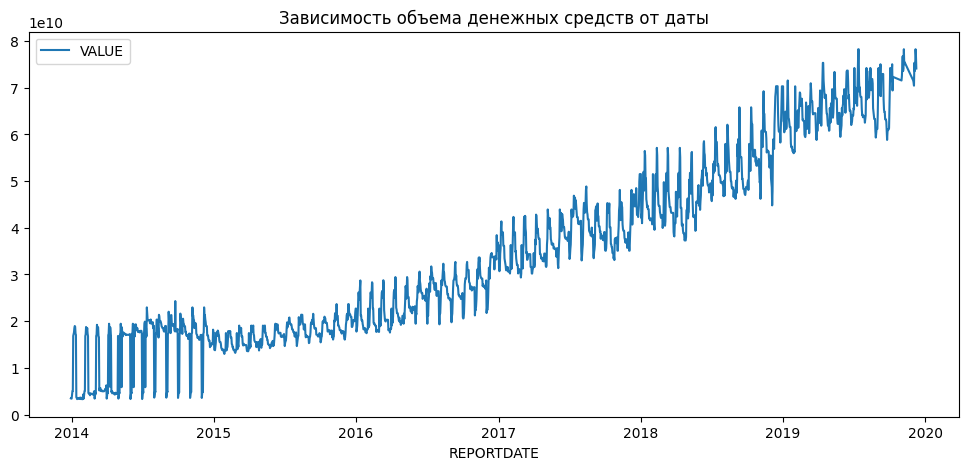

In [200]:
plt.figure( figsize = ( 12 , 5 ))
sns.lineplot(df).set_title("Зависимость объема денежных средств от даты")

Прослеживается корреляция между датой и объемом

# 2. Анализ данных

## В связи со странным поведением графика в начале отбросим все до 2015 года

In [201]:
df1 = df['2015-01-01':]

In [202]:
df1.head()

,VALUE
REPORTDATE,
2015-01-01,17452425921
2015-01-02,13883178718
2015-01-03,13873474441
2015-01-04,13772002655
2015-01-05,14503358262


In [203]:
df1['rolling_mean'] = df.VALUE.rolling('30D').mean()

C:\Users\Shtab\AppData\Local\Temp\ipykernel_1684\3708176454.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['rolling_mean'] = df.VALUE.rolling('30D').mean()


Text(0.5, 1.0, 'Зависимость объема денежных средств от даты')

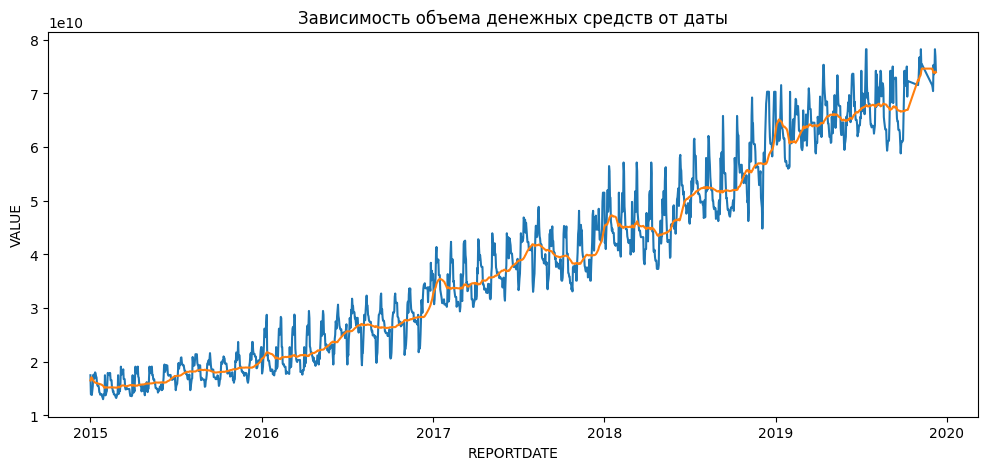

In [204]:
plt.figure( figsize = ( 12 , 5 ))
sns.lineplot(x = df1.index,y = df1.VALUE,).set_title("Зависимость объема денежных средств от даты")
sns.lineplot(x = df1.index,y = df1.rolling_mean,).set_title("Зависимость объема денежных средств от даты")

## Взглянем на ежегодную статистику

In [205]:
df_2015_2016 = df1[:'2016-01-01']
df_2016_2017 = df1['2016-01-01':'2017-01-01']
df_2017_2018 = df1['2017-01-01':'2018-01-01']
df_2018_2019 = df1['2018-01-01':'2019-01-01']
df_2019_2020 = df1['2019-01-01':]

In [206]:
def graf(data):
    plt.figure( figsize = ( 12 , 5 ))
    year = data.index[0].year
    sns.lineplot(x = data.index, y = data.VALUE).set_title(year)
    sns.lineplot(x = data.index, y = data.rolling_mean)

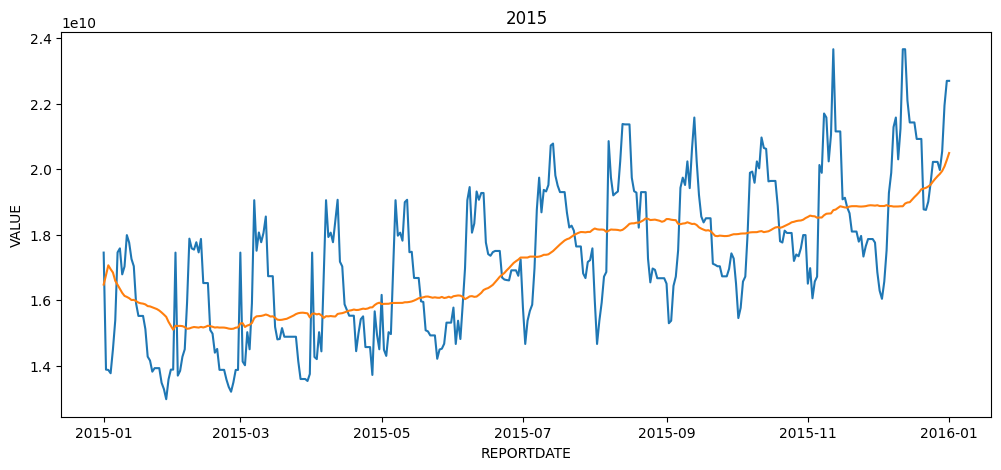

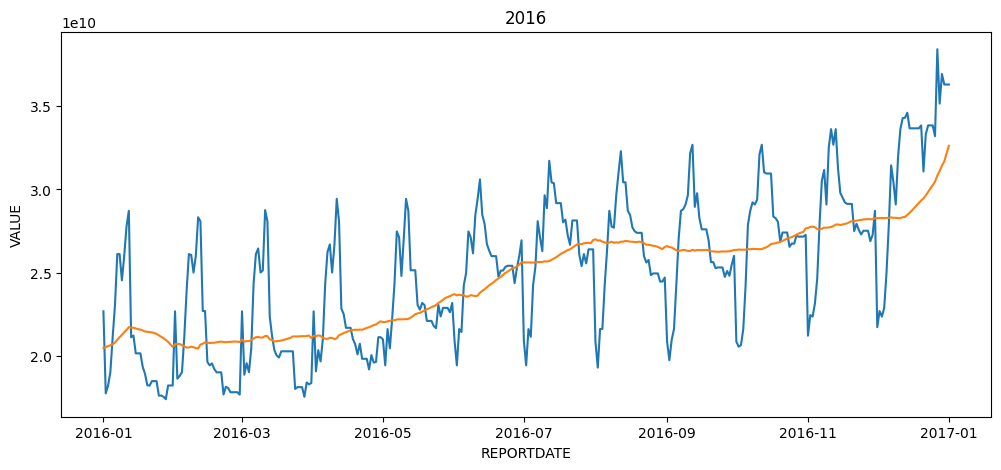

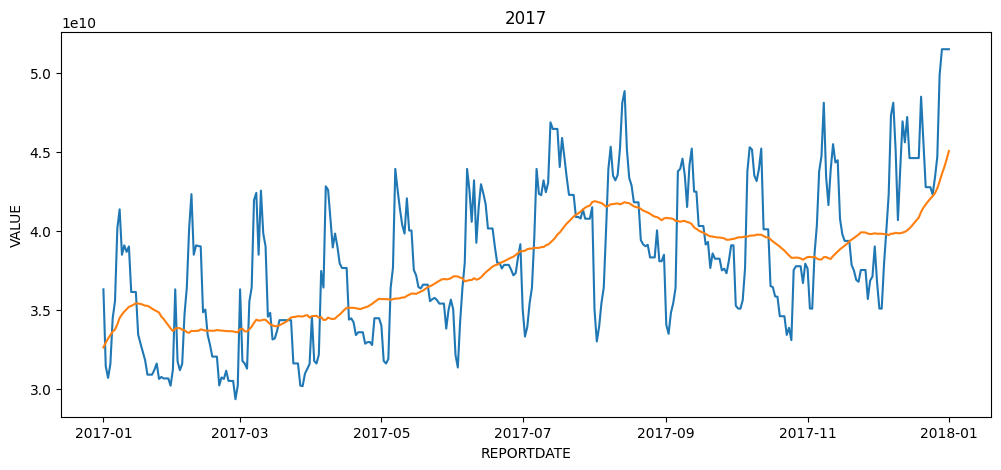

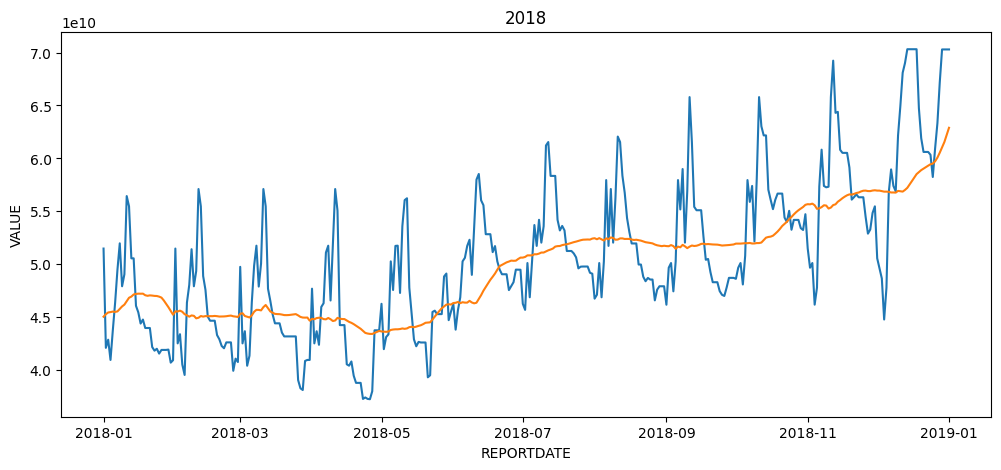

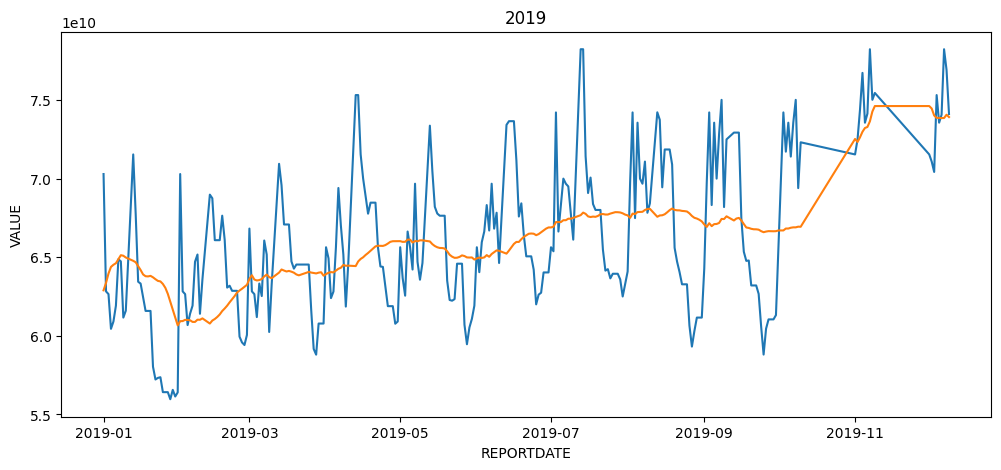

In [207]:
graf(df_2015_2016)
graf(df_2016_2017)
graf(df_2017_2018)
graf(df_2018_2019)
graf(df_2019_2020)

1. Как мы можем заметить, в период с 2015 года по 2019 в конце каждого года в среднем объем расчетных счетов больше, чем в начале (Денег становится больше) 
2. К 30 числу каждого месяца объем расчетных счетов опускается в локальный минимум, затем растет и к 14 числу каждого следующего месяца достигает локального максимума, затем опять к 30 числу того же месяца опускается в локальный минимум. Возможно это связано с получением зарплаты. Нужно сделать интервалы по числам.
3. Также мы видим, что за Январь каждого года объем увеличивается и уменьшается, с февраля по июль увеличивается, с июля по октябрь уменьшается и затем до конца года увеличивается. Возможно это связано с Новым годом, и с летними отпусками. Нужно сделать интервалы по месяцам

# 3. Feature engineering

## Добавим интервалы по числам и месяцам

In [208]:
DAY1 = []
DAY2 = []
for elem in df1.index:
    if elem.day <= 14:
        DAY1.append(elem.day)
        DAY2.append(0)
    else:
        DAY1.append(0)
        DAY2.append(elem.day)
        
Jan = []
Feb_Jul = []
Jul_Oct = []
Oct_Dec = []
for elem in df1.index:
    if elem.month ==1:
        Jan.append(elem.month)
        Feb_Jul.append(0)
        Jul_Oct.append(0)
        Oct_Dec.append(0)
    elif elem.month > 1 and elem.month <= 7:
        Jan.append(0)
        Feb_Jul.append(elem.month)
        Jul_Oct.append(0)
        Oct_Dec.append(0)
    elif elem.month > 7 and elem.month <= 10:
        Jan.append(0)
        Feb_Jul.append(0)
        Jul_Oct.append(elem.month)
        Oct_Dec.append(0)
    else:
        Jan.append(0)
        Feb_Jul.append(0)
        Jul_Oct.append(0)
        Oct_Dec.append(elem.month)


In [209]:
df1['DAY1'] = DAY1
df1['DAY2'] = DAY2
df1['Jan'] = Jan
df1['Feb_Jul'] = Feb_Jul
df1['Jul_Oct'] = Jul_Oct
df1['Oct_Dec'] = Oct_Dec
df1['DAY'] = df1.index.day
df1['DATE'] = df1.index
from datetime import datetime
df1.DATE = (df1.DATE - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')

C:\Users\Shtab\AppData\Local\Temp\ipykernel_1684\3068051175.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['DAY1'] = DAY1
C:\Users\Shtab\AppData\Local\Temp\ipykernel_1684\3068051175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['DAY2'] = DAY2
C:\Users\Shtab\AppData\Local\Temp\ipykernel_1684\3068051175.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [211]:
df1 = df1.drop('DAY', axis = 1)
df1 = df1.drop('rolling_mean', axis = 1)

In [245]:
df1

,VALUE,DAY1,DAY2,Jan,Feb_Jul,Jul_Oct,Oct_Dec,DATE
REPORTDATE,,,,,,,,
2015-01-01,17452425921,1,0,1,0,0,0,1.420070e+09
2015-01-02,13883178718,2,0,1,0,0,0,1.420157e+09
2015-01-03,13873474441,3,0,1,0,0,0,1.420243e+09
2015-01-04,13772002655,4,0,1,0,0,0,1.420330e+09
2015-01-05,14503358262,5,0,1,0,0,0,1.420416e+09
...,...,...,...,...,...,...,...,...
2019-12-05,73555567407,5,0,0,0,0,12,1.575504e+09
2019-12-06,74062556441,6,0,0,0,0,12,1.575590e+09
2019-12-07,78228598454,7,0,0,0,0,12,1.575677e+09


Разобьем данные на тренировочные и тестовые фичи и таргеты

In [221]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df1.drop('VALUE', axis=1),df1.VALUE, test_size = 0.3, shuffle = False)

# 4. Подбор модели

## Линейная регрессия

Посмотрим, как показывают себя различные модели на тренировочных данных. Критерием качества будет средний показатель средней абсолютной ошибки на кросс-валидации. 

In [222]:
from sklearn.model_selection import cross_val_score

In [246]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
L_reg = LinearRegression()
cross_val_score(L_reg, X_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error').mean()

-2980857313.295695

Для линейной регрессии средний показатель средней абсолютной ошибки на кросс-валидации - 2980857313.295695

## Полиномиальная регрессия 2 степени

In [264]:
from sklearn.preprocessing import PolynomialFeatures
maes = []
P_reg = LinearRegression()
poly = PolynomialFeatures(2)
poly_df_train = poly.fit_transform(X_train)
cross_val_score(P_reg, poly_df_train, y_train, cv = 5, scoring = 'neg_mean_absolute_error').mean()

-3547605142.0629835

Для полиномиальной регрессии 2 степени средний показатель средней абсолютной ошибки на кросс-валидации - 3547605142.0629835

## Ridge регрессия

In [248]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
R_reg = Ridge()
parametrs = {'alpha': np.arange(0.1,1.1,0.1), 'max_iter' : range(1,1000,100)}
grid_Ridge = GridSearchCV(R_reg, parametrs, cv = 5,scoring = 'neg_mean_absolute_error')
grid_Ridge.fit(X_train, y_train)
best_grid_Ridge = grid_Ridge.best_estimator_
grid_Ridge.best_score_

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.24234e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.26852e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.38682e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.08902e-17): result may not be accurate.
  return linalg.solve

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.09742e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.61665e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.25663e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.27698e-17): result may not be accurate.
  return linalg.solve

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.63106e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.27093e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.28544e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.40147e-17): result may not be accurate.
  return linalg.solve

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.30236e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.41612e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.12261e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.65989e-17): result may not be accurate.
  return linalg.solve

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.42345e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.13101e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.6743e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.31381e-17): result may not be accurate.
  return linalg.solve(

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.31928e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.43077e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.1394e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.68871e-17): result may not be accurate.
  return linalg.solve(

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.1478e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.70312e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.3567e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.33621e-17): result may not be accurate.
  return linalg.solve(A

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=5.37099e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.34467e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.45275e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=3.16459e-17): result may not be accurate.
  return linalg.solve

-2980526507.866758

Для Ridge регрессии средний показатель средней абсолютной ошибки на кросс-валидации - 2980526507.866758

## Lasso регрессия

In [225]:
from sklearn import linear_model
Lasso_reg = linear_model.Lasso()
params = {'alpha': np.arange(0.1,1.1,0.1), 'max_iter' : range(1,1000,100)}
grid_Lasso = GridSearchCV(Lasso_reg, params, cv = 5,scoring = 'neg_mean_absolute_error')
grid_Lasso.fit(X_train, y_train)
best_Lasso = grid_Lasso.best_estimator_
grid_Lasso.best_score_

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.391e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.796e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.061e+21, tolerance: 1.329e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.360e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.091e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.416e+21, tolerance: 7.100e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.944e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.956e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.294e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.667e+21, tolerance: 1.329e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.391e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.796e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.807e+21, tolerance: 1.329e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.627e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

-2980857312.635982

Для Lasso регрессии средний показатель средней абсолютной ошибки на кросс-валидации - 2980857312.635982

In [249]:
from sklearn.linear_model import ElasticNet
El_reg = ElasticNet()
parametrs = {'alpha': np.arange(0.1,1.1,0.1), 'max_iter' : range(1,1000,100)}
grid_El = GridSearchCV(El_reg, parametrs, cv = 5,scoring = 'neg_mean_absolute_error')
grid_El.fit(X_train, y_train)
best_grid_El = grid_El.best_estimator_
grid_El.best_score_

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.471e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.783e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.381e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.266e+21, tolerance: 1.329e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.341e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.279e+21, tolerance: 1.329e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.678e+21, tolerance: 7.100e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.303e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.698e+21, tolerance: 7.100e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.456e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.386e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.276e+21, tolerance: 1.329e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.383e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.157e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.747e+21, tolerance: 7.100e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.410e+21, tolerance: 9.087e+18
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.326e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.392e+21, tolerance: 1.125e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.835e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.899e+21, tolerance: 1.114e+19
  model = cd_fast.enet_coordinate_descent(
C:\Users\Shtab\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

-2963776233.071752

Для ElasticNet регрессии средний показатель средней абсолютной ошибки на кросс-валидации - 2963776233.071752

Лучше себя проявила ElasticNet регрессия 

# 5. Тесты

## Полиномиальная регрессия со степенью 2

In [263]:
poly_df_train = poly.fit_transform(X_train)
poly_df_test = poly.fit_transform(X_test)
P_reg.fit(poly_df_train,y_train)
P_pred = P_reg.predict(poly_df_test)
mean_absolute_error(y_test,P_pred)

3247381439.4079285

## Линейная регрессия

In [251]:
L_reg = LinearRegression()
L_reg.fit(X_train,y_train)
L_pred = L_reg.predict(X_test)
mean_absolute_error(y_test,L_pred)

7039308640.746077

## Ridge регрессия

In [252]:
R_pred = best_grid_Ridge.predict(X_test)
mean_absolute_error(y_test,R_pred)

7040771158.628838

## Lasso регрессия

In [253]:
Lasso_pred = best_Lasso.predict(X_test)
mean_absolute_error(y_test,Lasso_pred)

7039308641.186642

## Комбинация Lasso и Ridge регрессии

In [254]:
El_pred = best_grid_El.predict(X_test)
mean_absolute_error(y_test,El_pred)

7101784039.4372835

На тестах полиномиальная регрессия второй степени проявила себя лучше всех и показала среднюю абсолютную ошибку в ~ 3.25 млрд. 

#  6. Визуализация и написание функций

Сравним предсказания Полиномиальной регрессии 2 степени с действительностью

Text(0.5, 1.0, 'Зависимость объема от даты на тестовых данных')

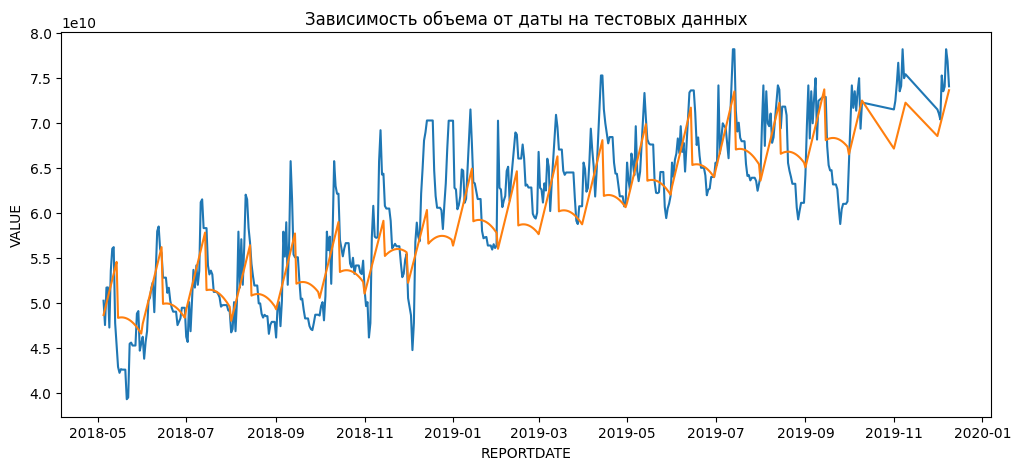

In [259]:
plt.figure( figsize = ( 12 , 5 ))
sns.lineplot(x = X_test.index, y = y_test)
sns.lineplot(x = X_test.index, y = P_pred).set_title('Зависимость объема от даты на тестовых данных')

Text(0.5, 1.0, 'Зависимость объема от даты на тренировочных данных')

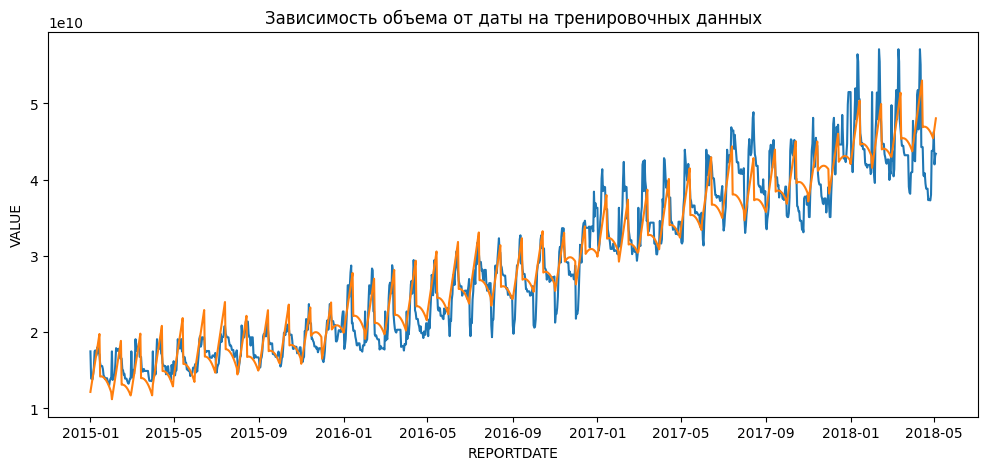

In [260]:
pred1 = P_reg.predict(poly_df_train)
plt.figure( figsize = ( 12 , 5 ))
sns.lineplot(x = X_train.index, y = y_train)
sns.lineplot(x = X_train.index, y = pred1).set_title('Зависимость объема от даты на тренировочных данных')

Несмотря на худшие показатели на кросс-валидации среди остальных моделей, полиномиальная регрессия второй степени довольно неплохо предсказала тренировочные данные, а на тестовых вообще проявила себя гораздо лучше других моделей линейной регрессии.

## Пропишем функции 

In [272]:
P_reg = LinearRegression()
poly_df_train = poly.fit_transform(X_train)
P_reg.fit(poly_df_train,y_train)
def value(features , M):
    poly_features = poly.fit_transform(features)
    P_pred = P_reg.predict(poly_features)
    return P_pred[M*30]
def scope(features, M):
    poly_features = poly.fit_transform(features)
    P_pred = P_reg.predict(poly_features)
    print("max",max(P_pred[:M*30]))
    print("min",min(P_pred[:M*30]))
    return max(P_pred[:M*30]), min(P_pred[:M*30])

In [271]:
value(X_test,1)

49653666682.01953

In [273]:
scope(X_test,1)

max 54592658391.89404
min 46627231635.18848


(54592658391.89404, 46627231635.18848)

Функция value принимает на вход Датасет с фичами и количество месяцев и возвращает предсказанное значение объема через данное кол-во месяцев.
Функция scope принимает на вход тот же Датасет и возвращает максимальное и минимальное значение объема за заданный промежуток месяцев.


# 7. Итог

## Имея лишь данные о значении объема расчетных счетов на дату, мы выделили полезные признаки и обучили на них модель.
## Протестировав ее, мы получили среднню абсолютную ошибку в 3.25 млрд.
## Написали функции, которые предсказывают нам максимально и минимальное значение за заданный промежуток времени.
## То есть, имея лишь датасет с датой, мы можем преобразовать его в удобный для модели датасет, добавив признаки дней и месяцев, и узнать приблизительное значение объема расчетных счетов в будущем